In [3]:
import pandas as pd
import numpy as np
from pybaseball import batting_stats
from pybaseball import playerid_lookup
from pybaseball import statcast, cache
import statsmodels.formula.api as smf
import warnings





In [4]:
# Suppress that specific FutureWarning message from pybaseball
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*errors='ignore' is deprecated.*"
)

# Enable caching
cache.enable()

# Load data
df_stat_2022 = statcast('2022-04-01', '2022-10-01')
df_stat_2023 = statcast('2023-04-01', '2023-10-01')

# Save to CSV
df_stat_2022.to_csv('df_stat_2022.csv', index=False)
df_stat_2023.to_csv('df_stat_2023.csv', index=False)




This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 184/184 [00:02<00:00, 74.46it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 184/184 [00:31<00:00,  5.80it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [5]:
# Load both years
df_2022 = batting_stats(2022)
df_2023 = batting_stats(2023, qual=200)

# Add year indicator
df_2022['year'] = 2022
df_2023['year'] = 2023
print(df_2023['Name'].head())

# # Example: lookup by name
playerid_lookup('Harper', 'Bryce')



1    Ronald Acuna Jr.
7     Freddie Freeman
4        Mookie Betts
6          Matt Olson
0       Shohei Ohtani
Name: Name, dtype: object
Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,harper,bryce,547180,harpb003,harpebr03,11579,2012.0,2025.0


In [6]:
unique_names_2023 = df_2023['Name'].dropna().unique()

# Initialize a list for storage
player_ids_2023 = []

# Loop through each name in 2023
for full_name in unique_names_2023:
    try:
        # Split into first and last name
        first_name, last_name = full_name.strip().split(' ', 1)

        # Use playerid_lookup
        lookup_result = playerid_lookup(last_name, first_name)

        # If result found, store the first key_mlbam
        if not lookup_result.empty:
            key_mlbam = lookup_result['key_mlbam'].values[0]
            player_ids_2023.append({'Name': full_name, 'key_mlbam': key_mlbam})
        else:
            player_ids_2023.append({'Name': full_name, 'key_mlbam': None})

    except Exception as e:
        player_ids_2023.append({'Name': full_name, 'key_mlbam': None})

# Convert the results to a DataFrame
id_df_2023 = pd.DataFrame(player_ids_2023)
print(id_df_2023)

unique_names_2022 = df_2022['Name'].dropna().unique()

# Initialize 2022 list for storage
player_ids_2022 = []

# Loop through each unique name
for full_name in unique_names_2022:
    try:
        first_name, last_name = full_name.strip().split(' ', 1)

        lookup_result = playerid_lookup(last_name, first_name)

        if not lookup_result.empty:
            key_mlbam = lookup_result['key_mlbam'].values[0]
            player_ids_2022.append({'Name': full_name, 'key_mlbam': key_mlbam})
        else:
            player_ids_2022.append({'Name': full_name, 'key_mlbam': None})

    except Exception as e:
        player_ids_2022.append({'Name': full_name, 'key_mlbam': None})

id_df_2022 = pd.DataFrame(player_ids_2022)
print(id_df_2022)

                 Name  key_mlbam
0    Ronald Acuna Jr.        NaN
1     Freddie Freeman   518692.0
2        Mookie Betts   605141.0
3          Matt Olson   621566.0
4       Shohei Ohtani   660271.0
..                ...        ...
357       Kris Bryant   592178.0
358       Jean Segura   516416.0
359      Gavin Sheets   657757.0
360     Harold Castro   605612.0
361  Jurickson Profar   595777.0

[362 rows x 2 columns]
                 Name  key_mlbam
0         Aaron Judge   592450.0
1       Nolan Arenado   571448.0
2       Manny Machado   592518.0
3         Jose Altuve        NaN
4    Paul Goldschmidt   502671.0
..                ...        ...
125     Andrew Vaughn   683734.0
126       Nelson Cruz   112906.0
127       MJ Melendez   669004.0
128     Jesus Aguilar        NaN
129      Yuli Gurriel   493329.0

[130 rows x 2 columns]


In [7]:
#Filter out na's
df_filtered_2022 = id_df_2022[id_df_2022['key_mlbam'].notna()]
df_filtered_2023 = id_df_2023[id_df_2023['key_mlbam'].notna()]


In [8]:
#Get Dominant Hand from df_stat
batter_to_hand_2023 = df_stat_2023.set_index('batter')['stand'].to_dict()
df_filtered_2023['dominant_hand'] = df_filtered_2023['key_mlbam'].map(batter_to_hand_2023)
batter_to_hand_2022 = df_stat_2022.set_index('batter')['stand'].to_dict()
df_filtered_2022['dominant_hand'] = df_filtered_2022['key_mlbam'].map(batter_to_hand_2022)


/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_48096/397675082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2023['dominant_hand'] = df_filtered_2023['key_mlbam'].map(batter_to_hand_2023)
/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_48096/397675082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2022['dominant_hand'] = df_filtered_2022['key_mlbam'].map(batter_to_hand_2022)


In [10]:
test_df = batting_stats(2023, qual=200)
print(test_df['Pull%+'].head())

1     97
7     89
4    113
6     93
0     95
Name: Pull%+, dtype: int64


In [11]:
##############################################################################################################
# DiD REGRESSION ON LEFTY PULL HEAVY HITTERS AFTER 2023 RULE CHANGE
##############################################################################################################

#Load batting stats
df_2022 = batting_stats(2022, qual=200)
df_2023 = batting_stats(2023, qual=200)
df_2022['year'] = 2022
df_2023['year'] = 2023

#Merge lefty info from external handedness dataframe (you already have df_filtered_2022 and df_filtered_2023)
df_filtered_2022['lefty'] = (df_filtered_2022['dominant_hand'] == 'L').astype(int)
df_filtered_2023['lefty'] = (df_filtered_2023['dominant_hand'] == 'L').astype(int)

df_2022 = df_2022.merge(df_filtered_2022[['Name', 'lefty']], on='Name', how='left')
df_2023 = df_2023.merge(df_filtered_2023[['Name', 'lefty']], on='Name', how='left')

#Combine both years
df_all = pd.concat([df_2022, df_2023], ignore_index=True)

#Keep players with data from both years and known handedness - DELETED THIS
# counts = df_all['IDfg'].value_counts()
# df_all = df_all[df_all['IDfg'].isin(counts[counts == 2].index)]
df_all = df_all[df_all['lefty'].notna()]

#Create high_pull dummy from Pull%+ (110 = pulls 10% more than league avg)
pull_threshold = 110
df_all['high_pull'] = (df_all['Pull%+'] >= pull_threshold).astype(int)

#Run DiD with triple interaction term
model = smf.ols('OBP ~ lefty * C(year) * high_pull', data=df_all).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OBP   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.284
Date:                Thu, 26 Jun 2025   Prob (F-statistic):            0.00208
Time:                        15:52:51   Log-Likelihood:                 843.02
No. Observations:                 416   AIC:                            -1670.
Df Residuals:                     408   BIC:                            -1638.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_48096/1525978250.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2022['lefty'] = (df_filtered_2022['dominant_hand'] == 'L').astype(int)
/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_48096/1525978250.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2023['lefty'] = (df_filtered_2023['dominant_hand'] == 'L').astype(int)


In [ ]:
##############################################################################################################
# PARALLEL ASSUMPTIONS CHECK
##############################################################################################################
# Suppress that specific FutureWarning message from pybaseball
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*errors='ignore' is deprecated.*"
)

# Enable caching
cache.enable()

# Load Statcast data from 2023
df_stat_2021 = statcast('2021-04-01', '2021-10-01')
df_stat_2020 = statcast('2020-04-01', '2020-10-01')

# Save to CSV
df_stat_2020.to_csv('df_stat_2020.csv', index=False)
df_stat_2021.to_csv('df_stat_2021.csv', index=False)



This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 184/184 [01:13<00:00,  2.51it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates


100%|███████████████████████████████████████████| 71/71 [00:48<00:00,  1.47it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [14]:

# Load both years
df_2020 = batting_stats(2020)
df_2021 = batting_stats(2021, qual=200)

# Add year indicator
df_2020['year'] = 2020
df_2021['year'] = 2021
print(df_2021['Name'].head())


# ----- 2020 -----
unique_names_2020 = df_2020['Name'].dropna().unique()

player_ids_2020 = []

for full_name in unique_names_2020:
    try:
        first_name, last_name = full_name.strip().split(' ', 1)
        lookup_result = playerid_lookup(last_name, first_name)

        if not lookup_result.empty:
            key_mlbam = lookup_result['key_mlbam'].values[0]
            player_ids_2020.append({'Name': full_name, 'key_mlbam': key_mlbam})
        else:
            player_ids_2020.append({'Name': full_name, 'key_mlbam': None})

    except Exception as e:
        player_ids_2020.append({'Name': full_name, 'key_mlbam': None})

id_df_2020 = pd.DataFrame(player_ids_2020)
print(id_df_2020)

# ----- 2021 -----
unique_names_2021 = df_2021['Name'].dropna().unique()

player_ids_2021 = []

for full_name in unique_names_2021:
    try:
        first_name, last_name = full_name.strip().split(' ', 1)
        lookup_result = playerid_lookup(last_name, first_name)

        if not lookup_result.empty:
            key_mlbam = lookup_result['key_mlbam'].values[0]
            player_ids_2021.append({'Name': full_name, 'key_mlbam': key_mlbam})
        else:
            player_ids_2021.append({'Name': full_name, 'key_mlbam': None})

    except Exception as e:
        player_ids_2021.append({'Name': full_name, 'key_mlbam': None})

id_df_2021 = pd.DataFrame(player_ids_2021)
print(id_df_2021)



17           Trea Turner
1              Juan Soto
8     Fernando Tatis Jr.
0           Bryce Harper
34          Jose Ramirez
Name: Name, dtype: object
                   Name  key_mlbam
0    Fernando Tatis Jr.        NaN
1          Jose Ramirez        NaN
2       Freddie Freeman   518692.0
3            Jose Abreu        NaN
4           Trea Turner   607208.0
..                  ...        ...
137     Eduardo Escobar   500871.0
138          Nick Solak   669256.0
139           Josh Bell   458679.0
140       J.D. Martinez        NaN
141     Jonathan Villar   542340.0

[142 rows x 2 columns]
                   Name  key_mlbam
0           Trea Turner   607208.0
1             Juan Soto   665742.0
2    Fernando Tatis Jr.        NaN
3          Bryce Harper   547180.0
4          Jose Ramirez        NaN
..                  ...        ...
357     Gregory Polanco   570256.0
358      Carter Kieboom   666198.0
359           Isan Diaz        NaN
360           Joe Panik   605412.0
361  Jackie Bradley 

In [17]:
df_filtered_2020 = id_df_2020[id_df_2020['key_mlbam'].notna()]
df_filtered_2021 = id_df_2021[id_df_2021['key_mlbam'].notna()]

In [18]:
# ----- 2020 -----
batter_to_hand_2020 = df_stat_2020.set_index('batter')['stand'].to_dict()
df_filtered_2020['dominant_hand'] = df_filtered_2020['key_mlbam'].map(batter_to_hand_2020)

# ----- 2021 -----
batter_to_hand_2021 = df_stat_2021.set_index('batter')['stand'].to_dict()
df_filtered_2021['dominant_hand'] = df_filtered_2021['key_mlbam'].map(batter_to_hand_2021)


/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_20617/666667684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2020['dominant_hand'] = df_filtered_2020['key_mlbam'].map(batter_to_hand_2020)
/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_20617/666667684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2021['dominant_hand'] = df_filtered_2021['key_mlbam'].map(batter_to_hand_2021)


In [40]:
# Step 1: Load batting stats
df_2022 = batting_stats(2022, qual=200)
df_2023 = batting_stats(2023, qual=200)
df_2022['year'] = 2022
df_2023['year'] = 2023

# Step 2: Merge lefty info from external handedness dataframe (you already have df_filtered_2022 and df_filtered_2023)
df_filtered_2022['lefty'] = (df_filtered_2022['dominant_hand'] == 'L').astype(int)
df_filtered_2023['lefty'] = (df_filtered_2023['dominant_hand'] == 'L').astype(int)

df_2022 = df_2022.merge(df_filtered_2022[['Name', 'lefty']], on='Name', how='left')
df_2023 = df_2023.merge(df_filtered_2023[['Name', 'lefty']], on='Name', how='left')

#####2020 AND 2021

# Step 1: Load data
df_2020 = batting_stats(2020, qual=200)
df_2021 = batting_stats(2021, qual=200)
df_2020['year'] = 2020
df_2021['year'] = 2021

# Step 2: Merge lefty info from external handedness dataframes
df_filtered_2020['lefty'] = (df_filtered_2020['dominant_hand'] == 'L').astype(int)
df_filtered_2021['lefty'] = (df_filtered_2021['dominant_hand'] == 'L').astype(int)

df_2020 = df_2020.merge(df_filtered_2020[['Name', 'lefty']], on='Name', how='left')
df_2021 = df_2021.merge(df_filtered_2021[['Name', 'lefty']], on='Name', how='left')

/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_20617/628272602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2022['lefty'] = (df_filtered_2022['dominant_hand'] == 'L').astype(int)
/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_20617/628272602.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_2023['lefty'] = (df_filtered_2023['dominant_hand'] == 'L').astype(int)
/var/folders/7r/gd_3jt3n5lqcwpyx538q_jjw0000gn/T/ipykernel_20617/628272602.py:23: SettingWit

In [56]:
df_2020_filt = df_2020[['IDfg', 'Name', 'year', 'lefty', 'Pull%+', 'OBP']]
df_2021_filt = df_2021[['IDfg', 'Name', 'year', 'lefty', 'Pull%+', 'OBP']]
df_2022_filt = df_2022[['IDfg', 'Name', 'year', 'lefty', 'Pull%+', 'OBP']]
df_2023_filt = df_2023[['IDfg', 'Name', 'year', 'lefty', 'Pull%+', 'OBP']]

print(df_2020_filt.head())
df_pretrend = pd.concat([df_2020_filt, df_2021_filt, df_2022_filt, df_2023_filt], ignore_index=True)
# Count how many years each player appears in
counts = df_pretrend['IDfg'].value_counts()
common_ids = counts[counts == 4].index

# # Filter to players in all 3 years
# df_pretrend = df_pretrend[df_pretrend['IDfg'].isin(common_ids)].copy()

# Define high_pull and treated
df_pretrend['high_pull'] = (df_pretrend['Pull%+'] >= 110).astype(int)
df_pretrend['treated'] = ((df_pretrend['lefty'] == 1) & (df_pretrend['high_pull'] == 1)).astype(int)





    IDfg                Name  year  lefty  Pull%+    OBP
0  19709  Fernando Tatis Jr.  2020    NaN     109  0.366
1  13510        Jose Ramirez  2020    NaN     126  0.386
2   5361     Freddie Freeman  2020    1.0      92  0.462
3  15676          Jose Abreu  2020    NaN      92  0.370
4  16252         Trea Turner  2020    0.0      75  0.394


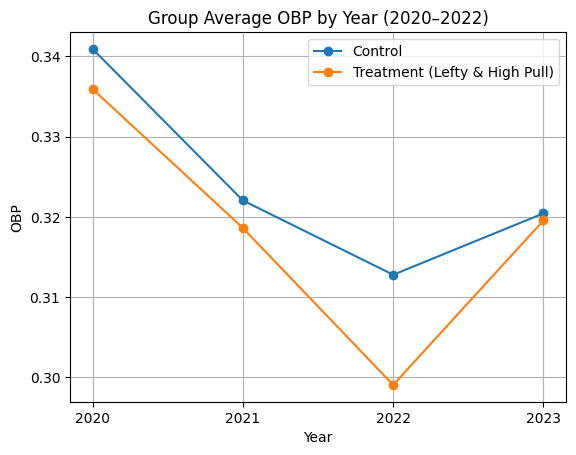

In [57]:
#PARALLEL TRENDS ASSUMPTION

# Group by year and treatment status, then take mean OBP
group_means = df_pretrend.groupby(['year', 'treated'])['OBP'].mean().reset_index()

# Make sure year is integer for clean axis labels
group_means['year'] = group_means['year'].astype(int)

# Plot
import matplotlib.pyplot as plt

for group in [0, 1]:
    df_plot = group_means[group_means['treated'] == group]
    label = "Treatment (Lefty & High Pull)" if group == 1 else "Control"
    plt.plot(df_plot['year'], df_plot['OBP'], marker='o', label=label)

plt.title("Group Average OBP by Year (2020–2022)")
plt.xlabel("Year")
plt.ylabel("OBP")
plt.xticks([2020, 2021, 2022, 2023])
plt.legend()
plt.grid(True)
plt.show()

